In [ ]:
# 📌 1. Cài đặt thư viện cần thiết
!pip install -q transformers datasets peft accelerate sentencepiece


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 37.4 MB/s eta 0:00:00


In [ ]:
# 📌 2. Import các thư viện
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer, DataCollatorForLanguageModeling
from datasets import load_dataset, Dataset
from peft import get_peft_model, LoraConfig, TaskType
import torch
import re
import pandas as pd

In [ ]:
# 📌 3. Tải mô hình BLOOM nhỏ (560M) và tokenizer
model_name = "bigscience/bloom-560m"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/222 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

In [ ]:
train_path = "/content/drive/MyDrive/NLP/train.json"
test_path = "/content/drive/MyDrive/NLP/test.json"

In [ ]:
# 📌 5. Đọc dữ liệu train.json
import json
with open(train_path, "r", encoding="utf-8") as f:
    train_raw = json.load(f)

# 📌 6. Đọc dữ liệu test.json
with open(test_path, "r", encoding="utf-8") as f:
    test_raw = json.load(f)

In [ ]:
# 📌 In 2 phần tử đầu tiên mỗi file, mỗi phần tử trên 1 dòng
print("Train:")
print(train_raw[0])
print(train_raw[1])

Train:
{'id': 'u7-1570446247_1', 'question': 'Quang Hải giành được chức vô địch U21 quốc gia năm bao nhiêu tuổi', 'title': 'Nguyễn Quang Hải (sinh 1997)', 'text': 'Năm 2013 , Nguyễn Quang Hải giành chức vô địch U21 quốc gia 2013 cùng với đội trẻ Hà Nội T&T và tạo nên cú sốc khi trở thành cầu thủ 16 tuổi đầu tiên giành được danh hiệu vô địch U21 quốc gia .', 'label': True}
{'id': 'u7-1570446247_2', 'question': 'Quang Hải giành được chức vô địch U21 quốc gia năm bao nhiêu tuổi', 'title': 'Nguyễn Quang Hải (sinh 1997)', 'text': 'Sau chức vô địch U-21 quốc gia 2013 , Nguyễn Quang Hải mới 16 tuổi lập tức được HLV Phan Thanh Hùng điền vào danh sách của đội bóng thủ đô tham dự V-League 2014 .', 'label': True}


In [ ]:
# 📌 7. Hàm chuyển đổi train.json sang định dạng text cho fine-tune
def convert_train_item(item):
    # Kết hợp question, title, text thành một đoạn hội thoại
    prompt = f"Người dùng: {item['question']}\nChatbot:"
    answer = item.get("text", "")
    return {"text": prompt + " " + answer}

train_data = [convert_train_item(item) for item in train_raw]

In [ ]:
def convert_test_item(item):
    paragraphs_text = " ".join([p["text"] for p in item.get("paragraphs", [])])
    prompt = f"Người dùng: {item.get('question', '')}\nChatbot:"
    answer = paragraphs_text
    return {"text": prompt + " " + answer}

# Giả sử test_raw là list các dict
test_data = [convert_test_item(item) for item in test_raw]

from datasets import Dataset
test_dataset = Dataset.from_list(test_data)

In [ ]:
test_dataset[0]

{'text': 'Người dùng: Toà nhà nào cao nhất Việt Nam\nChatbot: The Landmark 81 là một toà nhà chọc trời trong tổ hợp dự án Vinhomes Tân Cảng , một dự án có tổng mức đầu tư 40.000 tỷ đồng , do Công ty Cổ phần Đầu tư xây dựng Tân Liên Phát thuộc Vingroup làm chủ đầu tư . Toà tháp cao 81 tầng , hiện tại là toà nhà cao nhất Việt Nam và là toà nhà cao nhất Đông Nam Á từ tháng 3 năm 2018 . Toà tháp cao 81 tầng , hiện tại là toà nhà cao nhất Việt Nam và là toà nhà cao nhất Đông Nam Á từ tháng 3 năm 2018 . Dự án được xây dựng ở Tân Cảng , quận Bình Thạnh , ven sông Sài Gòn . Dự án được khởi công ngày 26/07/2014 .'}

In [ ]:
# 📌 9. Tạo dataset HuggingFace từ list dict
train_dataset = Dataset.from_pandas(pd.DataFrame(train_data))
test_dataset = Dataset.from_pandas(pd.DataFrame(test_data))

In [ ]:
# 📌 11. Làm sạch văn bản
def clean_text(example):
    text = example["text"]
    text = re.sub(r"[^\w\s\n]", "", text)  # loại bỏ kí tự đặc biệt
    text = re.sub(r"\s+", " ", text).strip()
    return {"text": text}

train_dataset = train_dataset.map(clean_text)
test_dataset = test_dataset.map(clean_text)

Map:   0%|          | 0/18108 [00:00<?, ? examples/s]

Map:   0%|          | 0/501 [00:00<?, ? examples/s]

In [ ]:
print(train_dataset[0])

{'text': 'Người dùng Quang Hải giành được chức vô địch U21 quốc gia năm bao nhiêu tuổi Chatbot Năm 2013 Nguyễn Quang Hải giành chức vô địch U21 quốc gia 2013 cùng với đội trẻ Hà Nội TT và tạo nên cú sốc khi trở thành cầu thủ 16 tuổi đầu tiên giành được danh hiệu vô địch U21 quốc gia'}


In [ ]:
def tokenize_fn(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=64)
train_tokenized = train_dataset.map(tokenize_fn, batched=True)
test_tokenized = test_dataset.map(tokenize_fn, batched=True)


Map:   0%|          | 0/18108 [00:00<?, ? examples/s]

Map:   0%|          | 0/501 [00:00<?, ? examples/s]

In [ ]:
print(train_tokenized[0])

{'text': 'Người dùng Quang Hải giành được chức vô địch U21 quốc gia năm bao nhiêu tuổi Chatbot Năm 2013 Nguyễn Quang Hải giành chức vô địch U21 quốc gia 2013 cùng với đội trẻ Hà Nội TT và tạo nên cú sốc khi trở thành cầu thủ 16 tuổi đầu tiên giành được danh hiệu vô địch U21 quốc gia', 'input_ids': [26765, 12406, 46844, 21872, 48788, 2001, 6968, 12740, 39395, 764, 4093, 8916, 4290, 3683, 8124, 31937, 12281, 92323, 37143, 42353, 6134, 15311, 46844, 21872, 48788, 6968, 12740, 39395, 764, 4093, 8916, 4290, 6134, 6228, 2474, 13467, 15831, 9261, 13215, 61633, 1123, 11818, 6779, 42052, 175824, 3582, 8846, 4361, 8896, 9516, 2636, 12281, 4379, 12321, 48788, 2001, 16961, 12735, 12740, 39395, 764, 4093, 8916, 4290], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [ ]:
# 📌 14. Cấu hình PEFT LoRA để fine-tune nhẹ
peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    r=4,
    lora_alpha=16,
    lora_dropout=0.1,
    bias="none"
)
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

trainable params: 393,216 || all params: 559,607,808 || trainable%: 0.0703


In [ ]:
# 📌 16. Data collator (không dùng MLM)
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

In [ ]:
from transformers import TrainingArguments, Trainer
import matplotlib.pyplot as plt

training_args = TrainingArguments(
    output_dir="./chatbot_output",
    per_device_train_batch_size=2,
    num_train_epochs=1,
    learning_rate=2e-4,
    logging_steps=5,
    save_strategy="no",     # Không lưu giữa chừng
    report_to="none"
)

In [ ]:


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=test_tokenized,   # dùng để evaluate
    tokenizer=tokenizer,
    data_collator=data_collator
)

In [ ]:
# 📉 Huấn luyện và đánh giá từng epoch
eval_losses = []

for epoch in range(int(training_args.num_train_epochs)):
    print(f"\n📌 === Epoch {epoch+1} ===")

    trainer.train()

    eval_result = trainer.evaluate()
    print(f"📊 Evaluation loss: {eval_result['eval_loss']}")
    eval_losses.append(eval_result["eval_loss"])

# 📊 Vẽ biểu đồ loss theo epoch
plt.plot(range(1, len(eval_losses) + 1), eval_losses, marker='o')
plt.title("Evaluation Loss theo Epoch")
plt.xlabel("Epoch")
plt.ylabel("Eval Loss")
plt.grid(True)
plt.show()


In [ ]:
!pip install transformers peft torch -q

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel, PeftConfig
import torch

# Đường dẫn adapter
adapter_path = "/content/drive/MyDrive/NLP/chatbot_output_continue/checkpoint-45270"

# Load cấu hình adapter
peft_config = PeftConfig.from_pretrained(adapter_path)

# Load base model gốc tương ứng với adapter
base_model = AutoModelForCausalLM.from_pretrained(peft_config.base_model_name_or_path)

# Load adapter vào base model
model = PeftModel.from_pretrained(base_model, adapter_path)
tokenizer = AutoTokenizer.from_pretrained(adapter_path)

model.eval()


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): BloomForCausalLM(
      (transformer): BloomModel(
        (word_embeddings): Embedding(250880, 1024)
        (word_embeddings_layernorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (h): ModuleList(
          (0-23): 24 x BloomBlock(
            (input_layernorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (self_attention): BloomAttention(
              (query_key_value): lora.Linear(
                (base_layer): Linear(in_features=1024, out_features=3072, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=1024, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=3072, bias=False)
                )
                (lora_em

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/NLP/chatbot_output_continue",
    per_device_train_batch_size=2,
    num_train_epochs=3,
    learning_rate=2e-4,
    logging_steps=5,
    save_strategy="epoch",   # Hoặc "no" nếu bạn không muốn lưu giữa chừng
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=test_tokenized,
    tokenizer=tokenizer,
    data_collator=data_collator
)

# Tiếp tục huấn luyện
trainer.train()


<ipython-input-15-dddc4243aadf>:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
5,3.817200
10,16.189800
15,22.287100
20,22.011800
25,14.335700
30,11.026400
35,12.973200
40,14.110900
45,17.346400
50,15.319200


TrainOutput(global_step=18108, training_loss=7.018005373305718, metrics={'train_runtime': 6837.4296, 'train_samples_per_second': 5.297, 'train_steps_per_second': 2.648, 'total_flos': 4209724958441472.0, 'train_loss': 7.018005373305718, 'epoch': 2.0})

In [ ]:
from peft import PeftModel, PeftConfig

# 1. Load lại model gốc BLOOM (hoặc model adapter gốc)
base_model = AutoModelForCausalLM.from_pretrained("bigscience/bloom-560m")
model = PeftModel.from_pretrained(base_model, "/content/drive/MyDrive/NLP/chatbot_output_continue/checkpoint-18108")

In [ ]:
model.print_trainable_parameters()

trainable params: 0 || all params: 559,607,808 || trainable%: 0.0000


In [ ]:
from peft import LoraConfig, get_peft_model

lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["query_key_value", "dense"],  # ✅ phù hợp với BLOOM
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(base_model, lora_config)
model.print_trainable_parameters()

trainable params: 1,179,648 || all params: 560,394,240 || trainable%: 0.2105


In [ ]:
from transformers import TrainerCallback

class LoggingCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            print(f">>> Step {state.global_step} | Loss: {logs.get('loss', 'n/a')}")

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/NLP/chatbot_output_continue",
    per_device_train_batch_size=2,
    num_train_epochs=5,
    learning_rate=2e-4,
    logging_steps=5,
    save_strategy="epoch",
    save_total_limit=1,  # Hoặc "no" nếu bạn không muốn lưu giữa chừng
    report_to="tensorboard",       # ✅ Bật TensorBoard
    logging_dir="/content/drive/MyDrive/NLP/logs_tb"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=test_tokenized,
    tokenizer=tokenizer,
    data_collator=data_collator,
    callbacks=[LoggingCallback()]  # <-- thêm callback
)

trainer.train()


/tmp/ipython-input-35-3693323433.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
5,2.918800
10,2.813400
15,2.987200
20,2.753500
25,2.866000
30,2.700100
35,2.800600
40,3.069300
45,3.216400
50,2.627200


Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
>>> Step 20275 | Loss: 3.4057
>>> Step 20280 | Loss: 3.4181
>>> Step 20285 | Loss: 2.9799
>>> Step 20290 | Loss: 4.0789
>>> Step 20295 | Loss: 3.5826
>>> Step 20300 | Loss: 2.9487
>>> Step 20305 | Loss: 2.9777
>>> Step 20310 | Loss: 3.0259
>>> Step 20315 | Loss: 3.0287
>>> Step 20320 | Loss: 2.8515
>>> Step 20325 | Loss: 5.2971
>>> Step 20330 | Loss: 3.6125
>>> Step 20335 | Loss: 3.9022
>>> Step 20340 | Loss: 3.6316
>>> Step 20345 | Loss: 3.0962
>>> Step 20350 | Loss: 3.2164
>>> Step 20355 | Loss: 3.5636
>>> Step 20360 | Loss: 3.2513
>>> Step 20365 | Loss: 3.6016
>>> Step 20370 | Loss: 3.0457
>>> Step 20375 | Loss: 3.2392
>>> Step 20380 | Loss: 3.3154
>>> Step 20385 | Loss: 3.0793
>>> Step 20390 | Loss: 3.1339
>>> Step 20395 | Loss: 3.9323
>>> Step 20400 | Loss: 3.5368
>>> Step 20405 | Loss: 3.7224
>>> Step 20410 | Loss: 3.7367
>>> Step 20415 | Loss: 3.7589
>>> Step 20420 | Loss: 3.9
>>> Step 20425 | Loss: 3.563
>>> Step 20430 | 

/usr/local/lib/python3.11/dist-packages/peft/utils/other.py:1110: UserWarning: Unable to fetch remote file due to the following error (ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: a3b4e482-1d1d-459b-9395-7c551bcdacf8)') - silently ignoring the lookup for the file config.json in bigscience/bloom-560m.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in bigscience/bloom-560m - will assume that the vocabulary was not modified.
  warnings.warn(


>>> Step 45270 | Loss: n/a


TrainOutput(global_step=45270, training_loss=3.106763391766507, metrics={'train_runtime': 6374.4896, 'train_samples_per_second': 14.203, 'train_steps_per_second': 7.102, 'total_flos': 1.05516545605632e+16, 'train_loss': 3.106763391766507, 'epoch': 5.0})

In [ ]:
for param in model.parameters():
    param.requires_grad = True


Test 2 epoch


In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

checkpoint_path = "/content/drive/MyDrive/NLP/chatbot_output_continue/checkpoint-9054"

tokenizer = AutoTokenizer.from_pretrained(checkpoint_path)
model = AutoModelForCausalLM.from_pretrained(checkpoint_path)


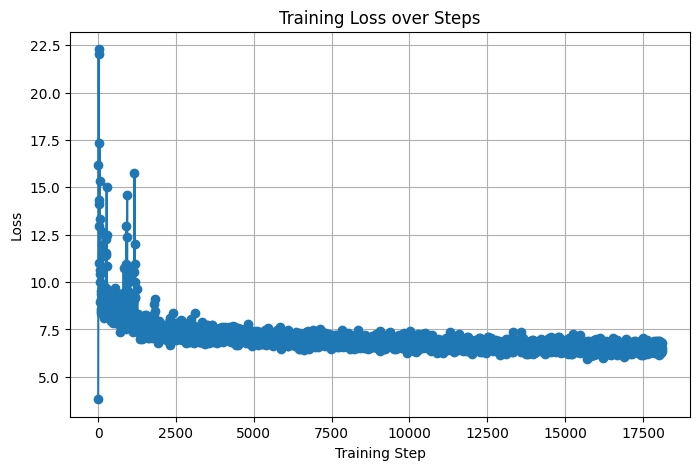

In [ ]:
import json
import matplotlib.pyplot as plt

# Đọc file trainer_state.json
path = "/content/drive/MyDrive/NLP/chatbot_output_continue/checkpoint-18108/trainer_state.json"
with open(path, "r") as f:
    trainer_state = json.load(f)

# Trích xuất loss theo step
log_history = trainer_state["log_history"]
steps, losses = [], []
for entry in log_history:
    if "loss" in entry:
        steps.append(entry["step"])
        losses.append(entry["loss"])

# Vẽ biểu đồ loss theo step
plt.figure(figsize=(8, 5))
plt.plot(steps, losses, marker='o')
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("Training Loss over Steps")
plt.grid(True)
plt.show()


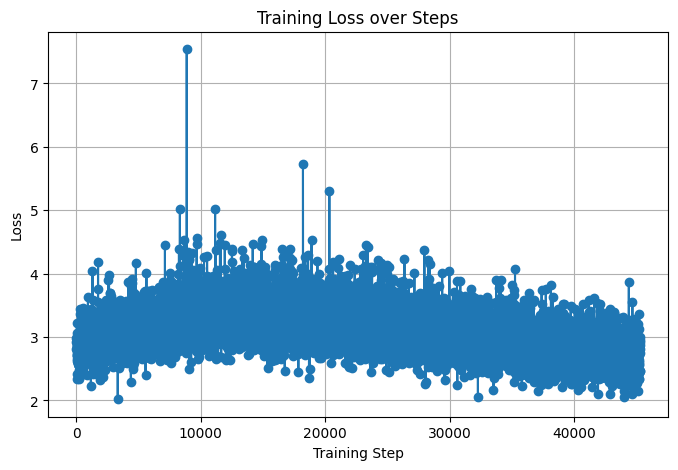

In [ ]:
import json
import matplotlib.pyplot as plt

# Đọc file trainer_state.json
path = "/content/drive/MyDrive/NLP/chatbot_output_continue/checkpoint-45270/trainer_state.json"
with open(path, "r") as f:
    trainer_state = json.load(f)

# Trích xuất loss theo step
log_history = trainer_state["log_history"]
steps, losses = [], []
for entry in log_history:
    if "loss" in entry:
        steps.append(entry["step"])
        losses.append(entry["loss"])

# Vẽ biểu đồ loss theo step
plt.figure(figsize=(8, 5))
plt.plot(steps, losses, marker='o')
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("Training Loss over Steps")
plt.grid(True)
plt.show()


**web**


In [ ]:
!pip install flask pyngrok transformers peft torch

In [ ]:
from flask import Flask, request, jsonify, render_template
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel, PeftConfig
import torch
import os
from pyngrok import ngrok

In [ ]:
# Khởi tạo Flask app
app = Flask(__name__)

In [ ]:
# Đường dẫn adapter
adapter_path = "/content/drive/MyDrive/NLP/chatbot_model_final"

In [ ]:
# Load cấu hình adapter và mô hình
peft_config = PeftConfig.from_pretrained(adapter_path)
base_model = AutoModelForCausalLM.from_pretrained(peft_config.base_model_name_or_path)
model = PeftModel.from_pretrained(base_model, adapter_path)
tokenizer = AutoTokenizer.from_pretrained(adapter_path)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
model.eval()

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): BloomForCausalLM(
      (transformer): BloomModel(
        (word_embeddings): Embedding(250880, 1024)
        (word_embeddings_layernorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (h): ModuleList(
          (0-23): 24 x BloomBlock(
            (input_layernorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (self_attention): BloomAttention(
              (query_key_value): lora.Linear(
                (base_layer): Linear(in_features=1024, out_features=3072, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=1024, out_features=4, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=4, out_features=3072, bias=False)
                )
                (lora_em

In [ ]:
import logging
# Thiết lập logging
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

In [ ]:
import os
# Kiểm tra đường dẫn adapter
if not os.path.exists(adapter_path):
    logger.error(f"Đường dẫn adapter {adapter_path} không tồn tại")
    raise FileNotFoundError(f"Đường dẫn adapter {adapter_path} không tồn tại")

# Khai báo device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info(f"Thiết bị sử dụng: {device}")

# Load cấu hình adapter và mô hình
try:
    peft_config = PeftConfig.from_pretrained(adapter_path)
    logger.info(f"Base model: {peft_config.base_model_name_or_path}")
    base_model = AutoModelForCausalLM.from_pretrained(peft_config.base_model_name_or_path, device_map="auto")
    model = PeftModel.from_pretrained(base_model, adapter_path)
    tokenizer = AutoTokenizer.from_pretrained(adapter_path)
except Exception as e:
    logger.error(f"Lỗi khi tải mô hình: {e}")
    raise RuntimeError(f"Lỗi khi tải mô hình: {e}")

# Đặt pad_token_id nếu cần
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id
    logger.info("Đã đặt pad_token_id bằng eos_token_id")

# Giải phóng VRAM
torch.cuda.empty_cache()

# Chuyển mô hình sang device
model.to(device)
for name, param in model.named_parameters():
    if param.device != device:
        logger.warning(f"Tham số {name} không ở trên {device}, đang ở {param.device}")
model.eval()
logger.info(f"Mô hình đã được tải và sẵn sàng trên {device}")


In [ ]:
# Hàm sinh văn bản
def generate_response(prompt, max_new_tokens=150):
    logger.debug(f"Nhận prompt: {prompt}")
    try:
        full_prompt = f"Người dùng: {prompt} \nChatbot:"
        inputs = tokenizer(full_prompt, return_tensors="pt")
        # Chuyển inputs sang device
        inputs = {k: v.to(device) for k, v in inputs.items()}
        logger.debug(f"Inputs ở trên thiết bị: {inputs['input_ids'].device}")
        torch.cuda.empty_cache()  # Giải phóng VRAM
        with torch.no_grad():
          outputs = model.generate(
            **inputs,
            max_new_tokens=150,
            do_sample=True,
            temperature=0.5,
            top_p=0.7,
            no_repeat_ngram_size=3,
            pad_token_id=tokenizer.eos_token_id
        )
        response = tokenizer.decode(outputs[0], skip_special_tokens=True)
        logger.debug(f"Phản hồi gốc: {response}")
        parts = response.split("Chatbot:")
        return parts[-1].strip() if len(parts) > 1 else response.strip()
    except Exception as e:
        logger.error(f"Lỗi khi sinh văn bản: {e}")
        raise

In [ ]:
# Route cho giao diện web
@app.route('/')
def home():
    return render_template('index.html')

In [ ]:
# Route cho API xử lý câu hỏi
@app.route('/chat', methods=['POST'])
def chat():
    data = request.json
    user_input = data.get('message', '')
    if not user_input:
        return jsonify({'error': 'No message provided'}), 400
    normalized_input = user_input.lower().replace("?", "").strip()
    if normalized_input in DEFAULT_ANSWERS:
        return jsonify({'response': DEFAULT_ANSWERS[normalized_input]})
    response = generate_response(user_input)
    return jsonify({'response': response})

In [ ]:
# Tạo file index.html
!mkdir -p templates
with open('templates/index.html', 'w') as f:
    f.write('''<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Chatbot</title>
    <style>
        * {
            margin: 0;
            padding: 0;
            box-sizing: border-box;
        }
        body {
            font-family: -apple-system, BlinkMacSystemFont, "Segoe UI", Roboto, Oxygen, Ubuntu, sans-serif;
            background-color: #f5f5f5;
            display: flex;
            justify-content: center;
            min-height: 100vh;
            padding: 20px;
        }
        .chat-container {
            width: 100%;
            max-width: 700px;
            background-color: white;
            border-radius: 10px;
            box-shadow: 0 0 15px rgba(0,0,0,0.1);
            overflow: hidden;
            display: flex;
            flex-direction: column;
            height: 80vh;
        }
        .chat-header {
            background-color: #202123;
            color: white;
            padding: 15px;
            text-align: center;
            font-size: 1.2em;
            font-weight: 500;
        }
        .chat-box {
            flex: 1;
            overflow-y: auto;
            padding: 20px;
            background-color: #f5f5f5;
            display: flex;
            flex-direction: column;
            gap: 10px;
        }
        .message {
            max-width: 70%;
            padding: 10px 15px;
            border-radius: 8px;
            line-height: 1.4;
        }
        .user {
            background-color: #007bff;
            color: white;
            align-self: flex-end;
        }
        .bot {
            background-color: #e9ecef;
            color: #333;
            align-self: flex-start;
        }
        .input-area {
            display: flex;
            padding: 15px;
            border-top: 1px solid #ddd;
            background-color: white;
        }
        input[type="text"] {
            flex: 1;
            padding: 10px;
            border: 1px solid #ccc;
            border-radius: 5px;
            font-size: 1em;
            outline: none;
        }
        button {
            padding: 10px 20px;
            margin-left: 10px;
            background-color: #007bff;
            color: white;
            border: none;
            border-radius: 5px;
            cursor: pointer;
            font-size: 1em;
        }
        button:hover {
            background-color: #0056b3;
        }
        /* Cuộn mượt */
        .chat-box::-webkit-scrollbar {
            width: 8px;
        }
        .chat-box::-webkit-scrollbar-track {
            background: #f1f1f1;
        }
        .chat-box::-webkit-scrollbar-thumb {
            background: #888;
            border-radius: 4px;
        }
        .chat-box::-webkit-scrollbar-thumb:hover {
            background: #555;
        }
    </style>
</head>
<body>
    <div class="chat-container">
        <div class="chat-header">Chatbot</div>
        <div class="chat-box" id="chat-box"></div>
        <div class="input-area">
            <input type="text" id="user-input" placeholder="Nhập câu hỏi của bạn...">
            <button onclick="sendMessage()">Gửi</button>
        </div>
    </div>

    <script>
        async function sendMessage() {
            const input = document.getElementById('user-input');
            const chatBox = document.getElementById('chat-box');
            const message = input.value.trim();
            if (!message) return;

            // Thêm tin nhắn người dùng
            chatBox.innerHTML += `<div class="message user">Bạn: ${message}</div>`;
            input.value = '';
            chatBox.scrollTop = chatBox.scrollHeight;

            try {
                const response = await fetch('/chat', {
                    method: 'POST',
                    headers: { 'Content-Type': 'application/json' },
                    body: JSON.stringify({ message })
                });
                const data = await response.json();
                if (data.error) {
                    chatBox.innerHTML += `<div class="message bot">Lỗi: ${data.error}</div>`;
                } else {
                    chatBox.innerHTML += `<div class="message bot">Chatbot: ${data.response}</div>`;
                }
            } catch (error) {
                chatBox.innerHTML += `<div class="message bot">Lỗi: Không thể kết nối đến server</div>`;
            }
            chatBox.scrollTop = chatBox.scrollHeight;
        }

        // Gửi khi nhấn Enter
        document.getElementById('user-input').addEventListener('keypress', (e) => {
            if (e.key === 'Enter') sendMessage();
        });
    </script>
</body>
</html>''')

In [ ]:
# Cấu hình ngrok
!ngrok authtoken 2yik2PJ3fibNk5ABy5r0kTTcOw6_6rGmboZev958X592tsR1b  # Thay YOUR_NGROK_AUTH_TOKEN bằng token của bạn
ngrok.kill()  # Đóng tunnel cũ
public_url = ngrok.connect(5000)
print(f"Public URL: {public_url}")
app.run()

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
Public URL: NgrokTunnel: "https://43f3-35-226-133-211.ngrok-free.app" -> "http://localhost:5000"
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [24/Jun/2025 09:53:24] "GET / HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [24/Jun/2025 09:53:24] "GET /favicon.ico HTTP/1.1" 404 -
